In [1]:
# import the project1-prepareData notebook:
!pip install ipynb
from ipynb.fs.full.project1_prepareData import *


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


./build_model.ipynb
./project1_logisticRegresion.ipynb
./adult.test
./project1_xgboost.ipynb
./README.md
./adult.names
./project1_decisionTree.ipynb
./old.adult.names
./adult.data
./project1_prepareData.ipynb
./server/.ipynb_checkpoints/build_model-checkpoint.ipynb
./.ipynb_checkpoints/project1-checkpoint.ipynb
./.ipynb_checkpoints/build_model-checkpoint.ipynb
./.ipynb_checkpoints/project-logisticRegresion-checkpoint.ipynb
./.ipynb_checkpoints/project1_logisticRegresion-checkpoint.ipynb
./.ipynb_checkpoints/project1_prepareData-checkpoint.ipynb
./.ipynb_checkpoints/project1_decisionTree-checkpoint.ipynb
./.ipynb_checkpoints/project1_xgboost-checkpoint.ipynb


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


'Low income people working fulltime by sex:'

sex,Female,Male
mean,0.839069,0.553859
count,3865.000000,9302.000000


'Low income people working fulltime by age:'

age,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,88,90
mean,0.657516,0.647594,0.646424,0.641992,0.607955,0.601983,0.600563,0.591508,0.600382,0.636036,0.561739,0.588441,0.597802,0.591518,0.573604,0.65285,0.667638,0.623145,0.656977,0.626506,0.673913,0.687259,0.737089,0.736559,0.734104,0.772059,0.727273,0.711712,0.755556,0.8125,0.75,0.777778,0.85,0.816327,0.684211,0.823529,0.931034,0.85,0.642857,0.6,0.9375,0.846154,1.0,0.6,0.875,1.0,1.0,1.0,0.8
count,765.000000,769.000000,741.000000,743.000000,704.000000,706.000000,711.000000,683.000000,523.000000,555.000000,575.000000,571.000000,455.000000,448.000000,394.000000,386.00000,343.000000,337.000000,344.000000,332.000000,276.000000,259.000000,213.000000,186.000000,173.000000,136.000000,110.000000,111.000000,90.000000,80.0000,64.00,54.000000,40.00,49.000000,38.000000,34.000000,29.000000,20.00,14.000000,15.0,16.0000,13.000000,7.0,5.0,8.000,3.0,1.0,3.0,35.0


'Low income people working fulltime by education:'

education,Doctorate,Prof-school,Masters,Bachelors,Assoc-voc,Assoc-acdm,Some-college,HS-grad,12th,10th,11th,9th,7th-8th,1st-4th,5th-6th,Preschool
mean,0.193431,0.202312,0.379147,0.442388,0.635359,0.642317,0.658268,0.753541,0.819048,0.863248,0.883333,0.911628,0.92328,0.933333,0.953947,1.0
count,274.000000,346.000000,1055.000000,2161.000000,543.000000,397.000000,2540.000000,4236.000000,105.000000,351.000000,300.000000,215.000000,378.00000,90.000000,152.000000,24.0


'Low income people working fulltime by country:'

native-country,Taiwan,Cambodia,Japan,India,Iran,Germany,Italy,England,Philippines,Canada,Ireland,United-States,France,South,China,Hong,Hungary,Scotland,Greece,Poland,Yugoslavia,Honduras,El-Salvador,Cuba,Haiti,Jamaica,Laos,Portugal,Puerto-Rico,Ecuador,Guatemala,Mexico,Vietnam,Trinadad&Tobago,Columbia,Dominican-Republic,Outlying-US(Guam-USVI-etc),Thailand,Peru,Nicaragua
mean,0.214286,0.375,0.444444,0.454545,0.5,0.54386,0.553191,0.568182,0.580247,0.607143,0.625,0.630316,0.636364,0.65625,0.666667,0.666667,0.666667,0.666667,0.681818,0.75,0.75,0.75,0.757576,0.807018,0.809524,0.814815,0.833333,0.857143,0.859649,0.875,0.875,0.89172,0.894737,0.909091,0.916667,1.0,1.0,1.0,1.0,1.0
count,14.000000,8.000,27.000000,44.000000,18.0,57.00000,47.000000,44.000000,81.000000,56.000000,8.000,12086.000000,11.000000,32.00000,39.000000,3.000000,9.000000,6.000000,22.000000,28.00,8.00,4.00,33.000000,57.000000,21.000000,27.000000,6.000000,14.000000,57.000000,8.000,16.000,157.00000,19.000000,11.000000,24.000000,30.0,7.0,7.0,13.0,8.0


'Selected data:'

,workclass,education,marital-status,occupation,relationship,race,sex,age,education-num,hours-per-week,low_income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,39,13,40,True
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,13,13,True
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,38,9,40,True
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,53,7,40,True
5,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,37,14,40,True
...,...,...,...,...,...,...,...,...,...,...,...
30157,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,27,12,38,True
30158,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,9,40,False
30159,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,58,9,40,True
30160,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,22,9,20,True


df_clean_filtered length:  27504
df_full_train length:  16502
df_train length:  16502
df_val length:  5501
df_test length:  5501
y_full_train length:  16502
y_train length:  16502
y_val length:  5501
y_test length:  5501


In [2]:
#Hot encoding and Logistic regretion
from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer

def train(dataFrame, y):
    # Hot Encoding
    dicts = dataFrame.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)

    # train
    model = linear_model.LogisticRegression()
    model.fit(X, y)
    return dv, model


dv, model = train(df_train, y_train)
weights = model.coef_[0].round(3) # weights
w0 = model.intercept_ # bias, w0

weights_with_featureNames = dict(zip(dv.get_feature_names(), weights))
print("w0 =", w0)
# display(weights_with_featureNames)
display(pd.DataFrame([weights], index=["weight"], columns=dv.get_feature_names()))



w0 = [2.44339]


/home/cristiandugacicu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,age,education-num,education=10th,education=11th,education=12th,education=1st-4th,education=5th-6th,education=7th-8th,education=9th,education=Assoc-acdm,...,relationship=Wife,sex=Female,sex=Male,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,workclass=State-gov,workclass=Without-pay
weight,-0.027,-0.169,0.752,0.869,0.258,0.064,0.133,0.651,0.497,0.38,...,-1.13,1.606,0.803,-0.162,0.59,0.391,0.067,0.848,0.643,0.032


In [3]:
# Predict

def predict(dataFrame, dv, model):
    dicts = dataFrame.to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred


proba = predict(df_val, dv, model)
y_pred_val = proba  #take column 1

low_salary_pred = (y_pred_val >= 0.5)
# customers_with_predicted_low_income = df_val[low_salary_pred]

In [4]:
# Check accuracy

#check average accuracy on y_val
df_pred = pd.DataFrame()
df_pred["probability"] = y_pred_val
df_pred["prediction"] = low_salary_pred.astype(int)
df_pred["actual"] = y_val
df_pred["prediction_correct"] = df_pred.prediction == df_pred.actual
display(df_pred)
print("Accuracy % on y_val:",df_pred.prediction_correct.mean())

,probability,prediction,actual,prediction_correct
0,0.644985,1,0,False
1,0.936231,1,1,True
2,0.988403,1,1,True
3,0.631713,1,1,True
4,0.367487,0,0,True
...,...,...,...,...
5496,0.684657,1,1,True
5497,0.848279,1,1,True
5498,0.928109,1,1,True
5499,0.854305,1,1,True


Accuracy % on y_val: 0.826576986002545


AUC for LogisticRegresion: 0.8800928825718033
ROC curve:


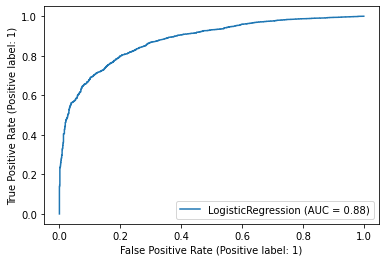

In [5]:
# AUC and ROC curve

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val)
auc = metrics.auc(fpr, tpr)

# print("thresholds:", thresholds)
print("AUC for LogisticRegresion:", auc)



import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, svm

dicts = df_val.to_dict(orient="records")
X_val = dv.transform(dicts)
print("ROC curve:")
metrics.plot_roc_curve(model, X_val, y_val) 
plt.show()
